In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.utils import shuffle


In [2]:
# Load annotations from CSV files
train_annotations = r"C:\Users\bethg\Downloads\Documents\VEHICULAR EMMISSIONS\images\roboflow\train\_annotations.csv"
valid_annotations = r"C:\Users\bethg\Downloads\Documents\VEHICULAR EMMISSIONS\images\roboflow\valid\_annotations.csv"
train_dir = r'C:\Users\bethg\Downloads\Documents\VEHICULAR EMMISSIONS\images\roboflow\train'
valid_dir = r'C:\Users\bethg\Downloads\Documents\VEHICULAR EMMISSIONS\images\roboflow\valid'


In [3]:
# Function to load and preprocess image
def load_image(image_path, img_size=(224, 224)):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=img_size)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img / 255.0  # Normalize pixel values
    return img

In [26]:
# Function to load and preprocess dataset
def load_dataset(annotations_file, image_dir, num_images=None):
    df = pd.read_csv(annotations_file)
    if num_images is not None:
        df = df[:num_images]  # Select first num_images rows
    image_paths = [os.path.join(image_dir, img) for img in df['filename']]
    images = [img_to_array(load_img(img, target_size=(224, 224))) for img in image_paths]
    
    # Scale bounding box coordinates
    width, height = 224, 224  # Assuming target size is 224x224
    bounding_boxes = df[['xmin', 'ymin', 'xmax', 'ymax']].values.astype(np.float64)
    bounding_boxes[:, [0, 2]] /= width
    bounding_boxes[:, [1, 3]] /= height
    
    labels = np.array(df['class'].map({'smoky': 1, 'non-smoky': 0}))  # Convert labels to numeric
    return np.array(images), bounding_boxes, labels

# Load and preprocess first 3000 images from the training dataset
num_train_images = 3500
train_images, train_bboxes, train_labels = load_dataset(train_annotations, train_dir, num_images=num_train_images)


In [8]:
# Load and preprocess training dataset
train_images, train_bboxes, train_labels = load_dataset(train_annotations, train_dir)

# Load and preprocess validation dataset
valid_images, valid_bboxes, valid_labels = load_dataset(valid_annotations, valid_dir)


In [11]:
print("Train Images Shape:", train_images.shape)
print("Train Bounding Boxes Shape:", train_bboxes.shape)
print("Train Labels Shape:", train_labels.shape)
print("Validation Images Shape:", valid_images.shape)
print("Validation Bounding Boxes Shape:", valid_bboxes.shape)
print("Validation Labels Shape:", valid_labels.shape)

Train Images Shape: (8209, 224, 224, 3)
Train Bounding Boxes Shape: (8209, 4)
Train Labels Shape: (8209,)
Validation Images Shape: (261, 224, 224, 3)
Validation Bounding Boxes Shape: (261, 4)
Validation Labels Shape: (261,)


In [19]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense

# Define input shape
input_shape = (224, 224, 3)

# Define input layers
input_layer = Input(shape=input_shape)

# Convolutional layers for image features
conv1 = Conv2D(32, (3, 3), activation='relu')(input_layer)
maxpool1 = MaxPooling2D((2, 2))(conv1)
conv2 = Conv2D(64, (3, 3), activation='relu')(maxpool1)
maxpool2 = MaxPooling2D((2, 2))(conv2)
conv3 = Conv2D(128, (3, 3), activation='relu')(maxpool2)
maxpool3 = MaxPooling2D((2, 2))(conv3)
flatten = Flatten()(maxpool3)

# Classification branch
dense_cls1 = Dense(128, activation='relu')(flatten)
output_class = Dense(1, activation='sigmoid', name='output_class')(dense_cls1)

# Bounding box regression branch
dense_bbox1 = Dense(128, activation='relu')(flatten)
output_bbox = Dense(4, name='output_bbox')(dense_bbox1)

# Combine both branches
model = Model(inputs=input_layer, outputs=[output_class, output_bbox])

model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_3 (Conv2D)           (None, 222, 222, 32)         896       ['input_2[0][0]']             
                                                                                                  
 max_pooling2d_3 (MaxPoolin  (None, 111, 111, 32)         0         ['conv2d_3[0][0]']            
 g2D)                                                                                             
                                                                                                  
 conv2d_4 (Conv2D)           (None, 109, 109, 64)         18496     ['max_pooling2d_3[0][0]'

In [28]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss={'output_class': BinaryCrossentropy(), 'output_bbox': MeanSquaredError()},
              metrics={'output_class': 'accuracy'})


In [17]:
# # Define callbacks
# callbacks = [
#     tf.keras.callbacks.EarlyStopping(monitor='val_loss', restore_best_weights=True)
# ]

Epoch 1/200
94/94 [==============================] - 149s 2s/step - loss: 0.5586 - output_class_loss: 0.2804 - output_bbox_loss: 0.2782 - output_class_accuracy: 0.8863
Epoch 2/200
94/94 [==============================] - 133s 1s/step - loss: 0.5015 - output_class_loss: 0.2549 - output_bbox_loss: 0.2465 - output_class_accuracy: 0.8920
Epoch 3/200
94/94 [==============================] - 131s 1s/step - loss: 0.4425 - output_class_loss: 0.2321 - output_bbox_loss: 0.2104 - output_class_accuracy: 0.9040
Epoch 4/200
94/94 [==============================] - 130s 1s/step - loss: 0.4082 - output_class_loss: 0.2174 - output_bbox_loss: 0.1908 - output_class_accuracy: 0.9063
Epoch 5/200
94/94 [==============================] - 131s 1s/step - loss: 0.3843 - output_class_loss: 0.2035 - output_bbox_loss: 0.1808 - output_class_accuracy: 0.9127
Epoch 6/200
94/94 [==============================] - 143s 2s/step - loss: 0.3682 - output_class_loss: 0.1973 - output_bbox_loss: 0.1709 - output_class_accuracy:

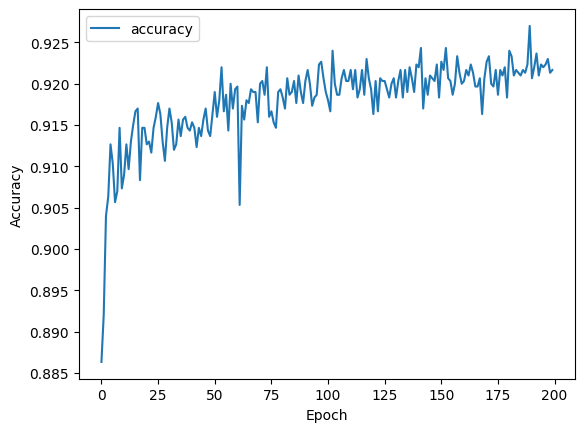

In [32]:
# Train the model
history = model.fit(train_images, {'output_class': train_labels, 'output_bbox': train_bboxes},
                    epochs=200, batch_size=32)

# Plot training history
plt.plot(history.history['output_class_accuracy'], label='accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()